
## Advanced Lane Finding

### The Goal:
As the next-level of lane finding (compared to project 1), the goal is to detect the lanes in more complex conditions which includes curves & different lighting condition. We would be using more techniques to achieve this goal.

### Steps:
1. Initial one-time step of Camera Calibration
    - Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Image Processing
    - Apply a distortion correction to raw images.
    - Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye or top-down view").
4. Detect lane pixels and fit to find the lane boundary.
    - Here we use different algorithms based on the existing FIT availability to increase the efficiency.
    - Also Sanity check is done on the calculated FIT and also the current values of various parameters.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

### Calibrating the Camera 
**Find & Save** the camera calibration matrix and distortion coefficients.

In [2]:
def camera_calib():
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Manually identified row and column corners in the calibration images
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Uncomment the below lines in debug mode to draw and display the corners
            #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
        else:
            print("No. of corners not matching, skipping: ", fname)
    cv2.destroyAllWindows()
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = camera_calib()
# Save the camera calibration result of dist & mtx
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.pkl", "wb" ) )

No. of corners not matching, skipping:  camera_cal/calibration5.jpg
No. of corners not matching, skipping:  camera_cal/calibration4.jpg
No. of corners not matching, skipping:  camera_cal/calibration1.jpg


### Undistoring the Images
Using the ** previously saved** camera calibration matrix and distortion coefficients to undistort any input image.

In [3]:
def undisto(img):
    # Read in the saved camera matrix and distortion coefficients
    dist_pickle = pickle.load( open( "calibration.pkl", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    undisto = cv2.undistort(img, mtx, dist, None, mtx)
    return undisto

### Testing the Undistortion
Test it one of the calibration image and on a test image.

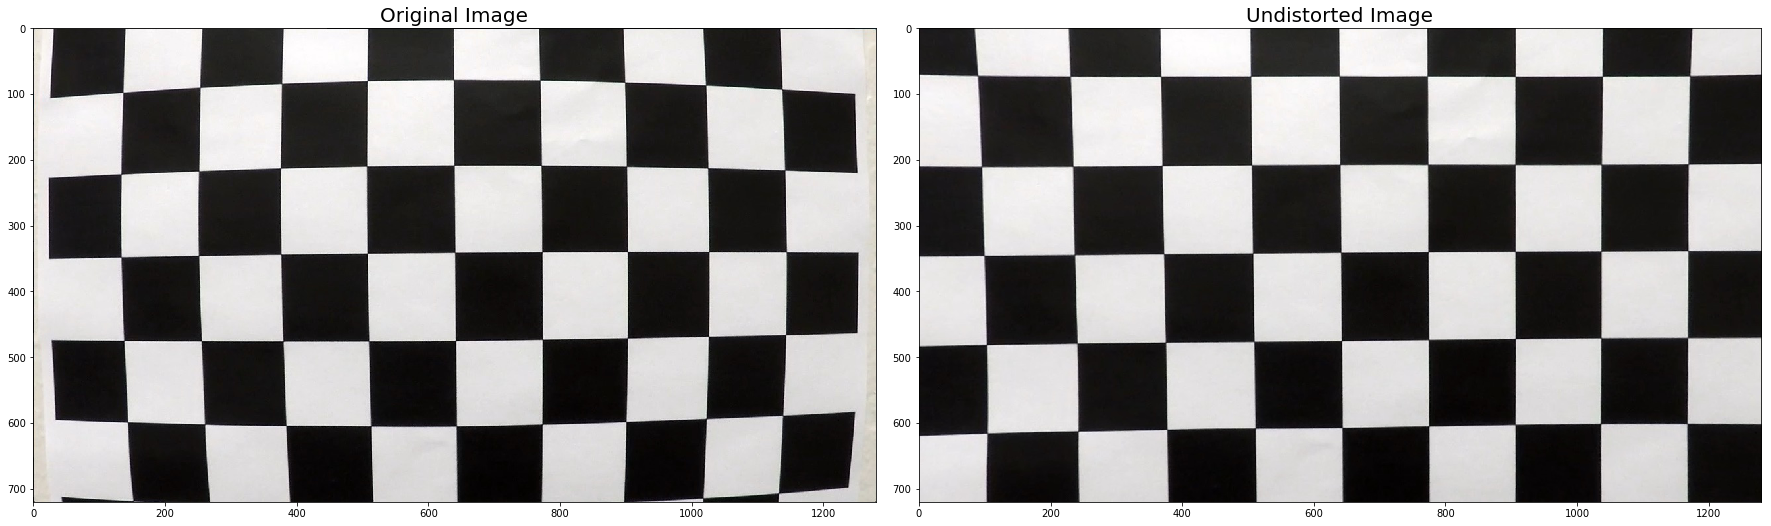

In [4]:
# Visulize Undistortion on a Calibration image

tst_img = mpimg.imread('camera_cal/calibration1.jpg')
undist = undisto(tst_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(tst_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

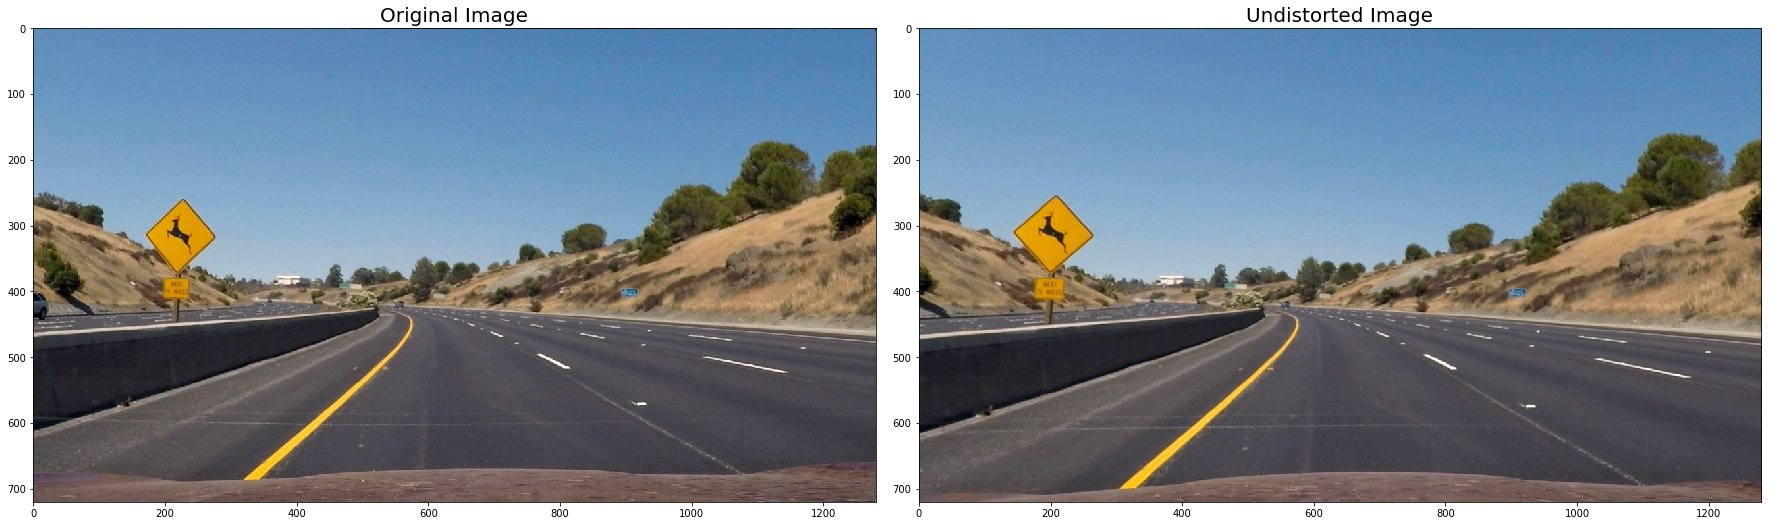

In [5]:
# Visulize Undistortion on a test image

tst_img = mpimg.imread('test_images/test2.jpg')
undist = undisto(tst_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(tst_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Helper Functions for Gradient Threshold
Here we define three differents ways of applying thresholds on the image for better detection of the shapes (particularly the lanes).

1. The SOBEL threshold is done either on x-axis or y-axis and looks for edges along the specified axis.
2. The MAGnitude threshold apply a threshold to the overall magnitude of the gradient, in both x and y. 
3. The GRADient DIRection threshold is used to detect only edges of a particular orientation. The direction of the gradient is simply the inverse tangent (arctangent) of the y gradient divided by the x gradient

In all the cases we can specify the threshold limits and also the size of the kernel (with larger kernel-size effecting a more smoothing effect).

In [9]:
# Absolute Gradient (along X or Y axis)
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0,255)):

    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

# Magnitude of the Gradient
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):

    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    abs_sobelxy = np.sqrt((sobelx ** 2) + (sobely ** 2))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return mag_binary

# Direction of the Gradient
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    atan = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(atan)
    dir_binary[(atan >= thresh[0]) & (atan <= thresh[1])] = 1
    # Return this mask as your binary_output image
    return dir_binary

### Threshold for Gradient & Color Space and apply Mask
Here we apply (on a trial-error basis) different combinations of the gradient thresholds that we defined above.

#### Color Spaces
Apart from the above, lane detection can be more effective in different color spaces with different thresholds for each channel within that color space. Here we experiment with both **RGB and HLS** color spaces.

The **ROI** (Region-of-Interest) mask is also defined in an approximate area where we expect to find the lane lines.

The final output is threshold with a good combination of above parameters.

In [10]:

def apply_grad_color_threshold(image):

    undist = undisto(image)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    # Run the function
    grad_binary = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(20,100))
    mag_binary = mag_thresh(gray, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(np.pi/6, np.pi/2))
    
    comb_grad_mag = ((grad_binary == 1) & (mag_binary == 1))
    comb_grad_dir = ((grad_binary == 1) & (dir_binary == 1))
    comb_mag_dir  = ((mag_binary == 1) & (dir_binary == 1))
    comb_all_three = ((grad_binary == 1) & (mag_binary == 1) & (dir_binary == 1))

    # We decide to go with a combination the gradient and direction thresholds.
    combined_condition = ((grad_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = image[:,:,0]
    G = image[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    height, width = gray.shape
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)

    return thresholded


### Testing Gradient & Color Thresholding and Applying mask

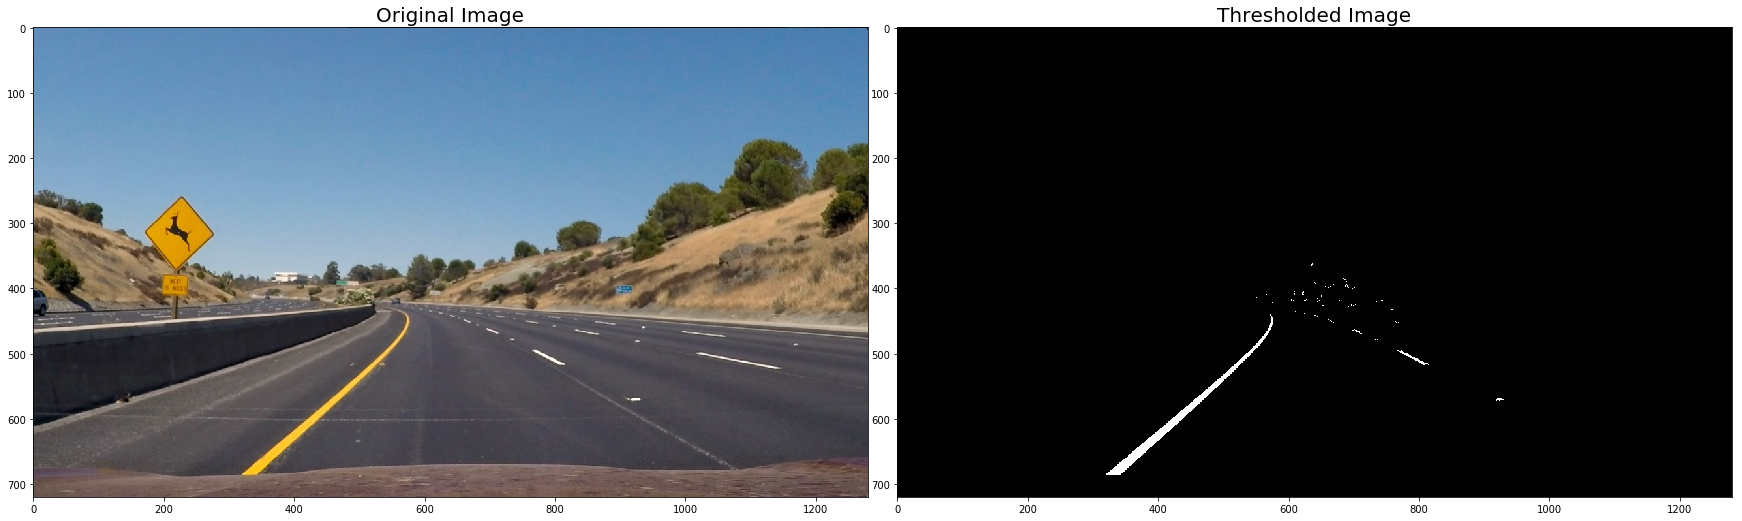

In [11]:
# Read in an image and grayscale it
image = mpimg.imread('test_images/test2.jpg')
th_img = apply_grad_color_threshold(image)

# Plot the result
f, (axes) = plt.subplots(nrows=1, ncols=2, figsize=(24,24))
ax1, ax2 = axes.flatten()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(th_img, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=20)
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

### Perspective Transformation
We apply a perpective transform to get a top-down (bird's eye) view of the the selected region. This is useful for calculating the lane curvature in the following steps.

A set of points in the source image and where we want to position these points in the destination image is defined. These points are used to calculate the perspective transform 'M' and the inverse perspective transform 'Minv'.

The perspective transform 'M' is applied on the image to get the transformed image. We also take out the inverse perspective transform 'Minv' to apply back to get original perspective towards the end.

In [12]:
def top_down_view(img):
    
    # define source and destination points for transform
    src = np.float32([[203, 720],[1099, 720], [707, 463],[580, 463]])
    dst = np.float32([[203, 720],[1099, 720], [1099, 0],[203, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

### Testing Top-Down View
Only top-down, **NOT** undistorted, grayed or thresholded

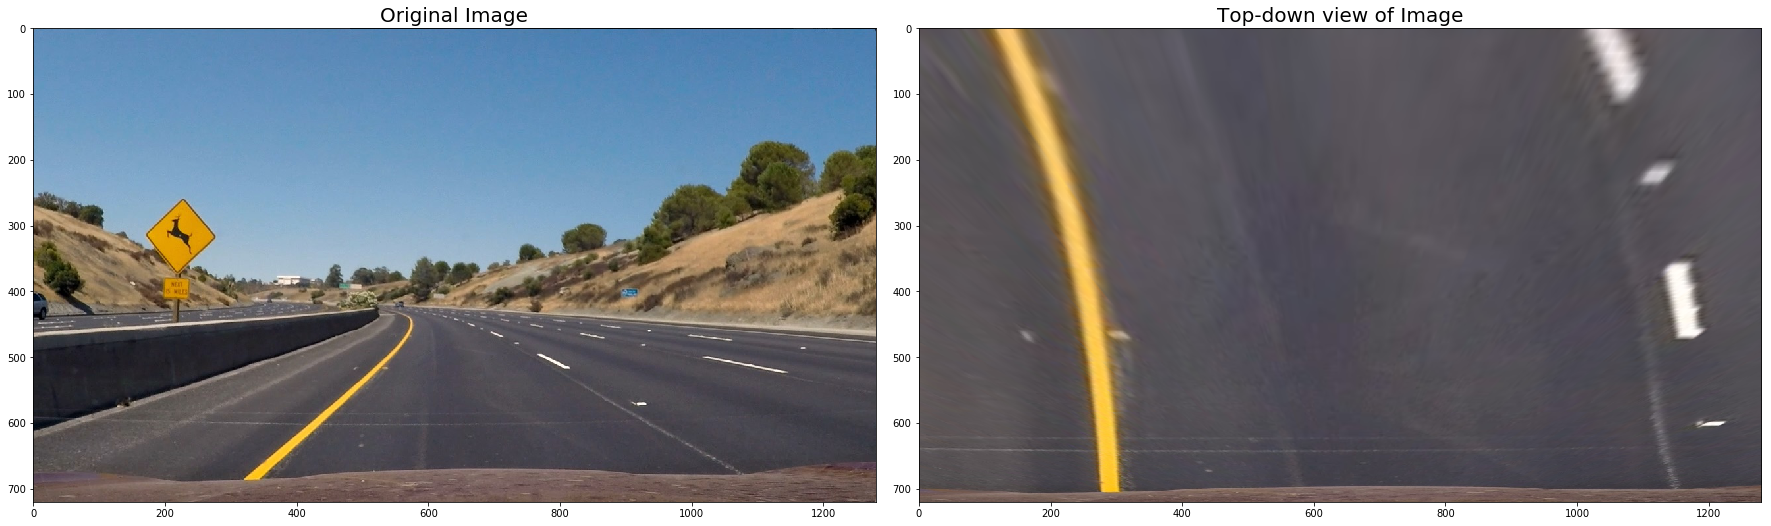

In [13]:
# Read in an image
img = mpimg.imread('test_images/test2.jpg')
top_down, perspective_M, Minv = top_down_view(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(top_down)
ax2.set_title('Top-down view of Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Testing out - Full Preprocessing
Undistort, Gray, Grad-thresh, Color-thresh, Top-Down

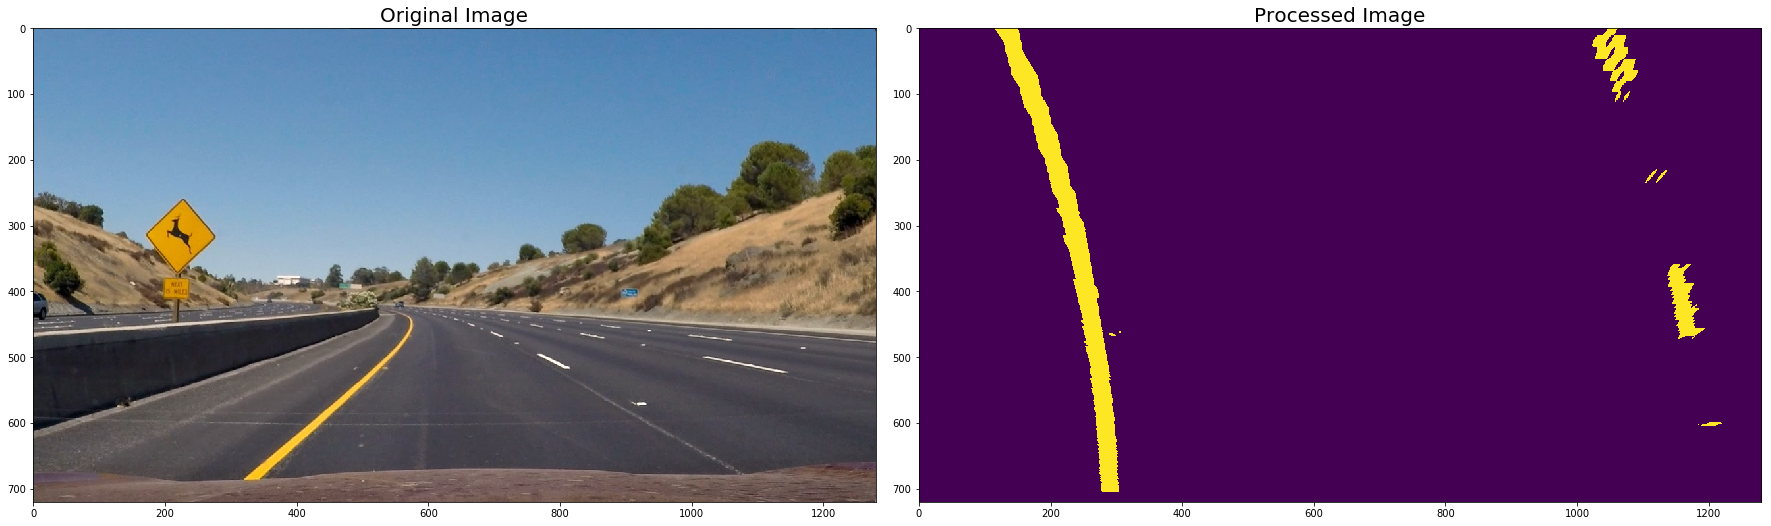

In [14]:
image = mpimg.imread('test_images/test2.jpg') # Read in an image
th_img = apply_grad_color_threshold(image) # undistort, gray & grad_color_threshold
top_down, perspective_M, Minv = top_down_view(th_img) # perspective transform

write_pic = (top_down*255).astype('uint8')
cv2.imwrite('output_images/top_down.jpg',write_pic) # Save the image for testing next few steps

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(top_down)
ax2.set_title('Processed Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

This completes steps 1 - 3 as outlined in the begining where we did the Camera Calibration and Image Processing

## Identifying the lanes.

In the next steps, we use the processed image to detect lane pixels and fit to find the lane boundary.

Initially to identify the lane we use the histogram to get a starting point and perform sliding-window algorithm. But as we do not expect the lane positions to change dramatically in each frame, we could focus our lane searching area in subsequent frames to a smaller area (last lane position +/- margin). For this we use an alternate algorithm.

However, we fall back on the sliding window if our sanity check fails in cases like no FIT found, substantial difference from last frame etc.

Below we can see how we identify the initial lane position using histogram.

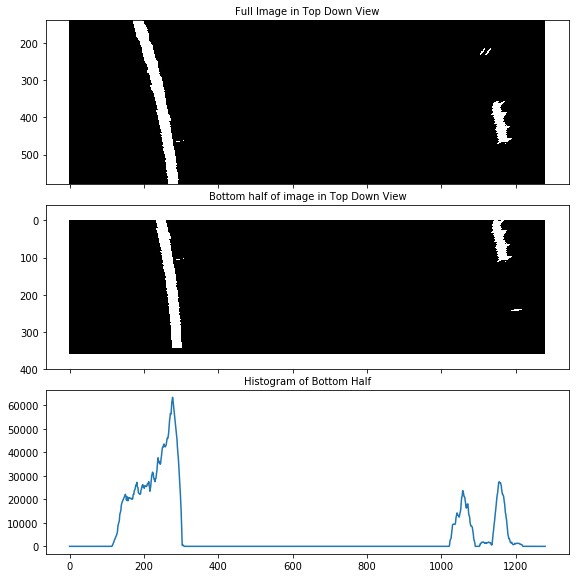

In [15]:
top_down = mpimg.imread('output_images/top_down.jpg')
bottom_half = top_down[top_down.shape[0]//2:,:]
histo = np.sum(top_down, axis=0)

# Visualize the resulting histogram
# Plot the result
f, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
ax1, ax2, ax3 = axes.flatten()
f.tight_layout()

ax1.imshow(top_down, cmap='gray')
ax1.set_title('Full Image in Top Down View', fontsize=10)


ax2.imshow(bottom_half, cmap='gray')
ax2.set_title('Bottom half of image in Top Down View', fontsize=10)

ax3.plot(histo)
ax3.set_title('Histogram of Bottom Half', fontsize=10)

plt.show()

## Finding Lane pixels from Image using Sliding Window
**Steps:**
* Use the histogram method mentioned above to identify initial position
* Define the hyperparameters 
 - number of sliding windows
 - width of the windows defined by margin
 - minimum number of pixels required to recenter window
* Identify the pixels in the defined area
* Check if reset is required based on minpix defined
* Calculate the FIT for the identified lane pixels

In [16]:
def slidingW_fit(binary_warped, debug_mode = False):
    """For the given image, this function outputs the left & right lane FIT
       and all the identified X-Y indices of left & right lanes"""

    # Take a histogram of the bottom half of the image
    # histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Taking full image histo since bottom half did not have enough pixels
    histogram = np.sum(binary_warped[:,:], axis=0)
    # Peak of left & right halves of histogram will be starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 15 # number of sliding windows
    margin = 60   # width of the windows +/- margin
    minpix = 50   # minimum number of pixels found to recenter window
    # height of windows is based on 'nwindows' and image height
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions (to be updated later for each window in nwindows)
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    out_img = None
    if debug_mode == True:
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (for right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug_mode == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
            
        # Identify the nonzero pixels in x and y within the current window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If count of current indices found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if debug_mode == True:
        # Color left lane RED and right lane BLUE
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
    l_fit, r_fit = (None, None)
    if len(leftx) != 0:
        l_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        r_fit = np.polyfit(righty, rightx, 2)
        
    # return leftx, lefty, rightx, righty, out_img
    return l_fit, r_fit, left_lane_inds, right_lane_inds, out_img



### Testing 
Testing the sliding window method with visualization

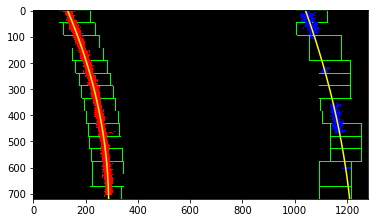

In [17]:
# Testing
def fit_polynomial_sss(binary_warped):

    left_fit, right_fit, _, _, out_img = slidingW_fit(binary_warped, debug_mode=True)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

# Testing
# Load our image - 
binary_warped = mpimg.imread('output_images/top_down.jpg')
out_img = fit_polynomial_sss(binary_warped)
plt.imshow(out_img)
plt.show()

## Searching from Prior FIT

Here we use the FIT from the previous frame to focus our lane searching area in subsequent frame to a smaller area (last lane position +/- margin).

- Define the margin
- Identify the active pixels
- Calculate the position using previous FIT details
- Define the new area with a +/- margin to previous position
- Identify the lane in the newly defined area
- Calculate the FIT for the identified lane pixels

In [18]:

def search_around_poly(binary_warped, last_lfit, last_rfit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    # Activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Calculate the position using previous FIT details and 
    # Define the new area with a +/- margin to previous position
    calc_lminx = (last_lfit[0]*(nonzeroy**2) + last_lfit[1]*nonzeroy + last_lfit[2] - margin)
    calc_lmaxx = (last_lfit[0]*(nonzeroy**2) + last_lfit[1]*nonzeroy + last_lfit[2] + margin)
    calc_rminx = (last_rfit[0]*(nonzeroy**2) + last_rfit[1]*nonzeroy + last_rfit[2] - margin)
    calc_rmaxx = (last_rfit[0]*(nonzeroy**2) + last_rfit[1]*nonzeroy + last_rfit[2] + margin)
    left_lane_inds  = ((nonzerox > calc_lminx) & (nonzerox < calc_lmaxx))
    right_lane_inds = ((nonzerox > calc_rminx) & (nonzerox < calc_rmaxx))
    
    # Extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    new_lfit, new_rfit = (None, None)
    if len(leftx) != 0:
        new_lfit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        new_rfit = np.polyfit(righty, rightx, 2)
    
    return new_lfit, new_rfit, left_lane_inds, right_lane_inds


### Testing search_around_poly

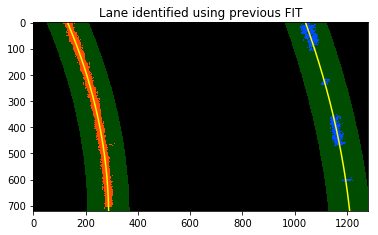

In [19]:
# Testing
# Load our image - assuming to be a new frame since last time!
binary_warped = mpimg.imread('output_images/top_down.jpg')

# For testing, using the same image as the frame from last time and generating the PREVIOUS-fit
left_fit, right_fit, _, _, _ = slidingW_fit(binary_warped, debug_mode=True)

# Calling search_around_poly using current frame image and fit from PREV frame (fake)
lfit, rfit, left_lane_inds, right_lane_inds = search_around_poly(binary_warped, left_fit, right_fit)

## Visualization ##
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Grab activated pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
# Calc both polynomials using ploty, left_fit and right_fit
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

margin = 80

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


# View your output
plt.title("Lane identified using previous FIT")
plt.imshow(result)
plt.show()

## Radius of Curvature

** (From class notes) **

In the above steps, we located the lane line pixels, used their x and y pixel positions to fit a second order polynomial curve as below:

$$  f(y) = Ay^2 + By + C $$

The radius of curvature at any point x of the function x=f(y) is given as follows ([tutorial](http://www.intmath.com/applications-differentiation/8-radius-curvature.php)):

$$ R_{curve} = \frac{[1 + (\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}$$

In the case of the second order polynomial above, the first and second derivatives are:

$$ f'(y) = \frac{dx}{dy} = 2Ay + B$$
$$ f''(y) = \frac{d^2x}{dy^2} = 2A$$

So, our equation for radius of curvature becomes:
$$ R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{\left |2A \right |} $$

In [20]:
def measure_curvature_pixels(img, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    y_mpp = 30/720 # meters per pixel in y dimension
    x_mpp = 3.7/700 # meters per pixel in x dimension
        
    try:
        ht, wd = img.shape
        # Define y-value where we want radius of curvature
        # Choose the maximum y-value, corresponding to the bottom of the image
        ploty = np.linspace(0, ht-1, ht)
        y_eval = np.max(ploty)

        left_fit_xint = left_fit[0]*ht**2 + left_fit[1]*ht + left_fit[2]
        right_fit_xint = right_fit[0]*ht**2 + right_fit[1]*ht + right_fit[2]

        ##### Calculation of R_curve (radius of curvature) #####
        left_curverad  = ((1 + (2*left_fit[0]*y_eval*y_mpp + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval*y_mpp + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        cam_pos = wd/2
        lane_cntr = (left_fit_xint + right_fit_xint)/2
        off_set = (cam_pos - lane_cntr) * x_mpp  # in meters

        return left_curverad, right_curverad, off_set
    except:
        return 0, 0, 0

### Testing Radius of Curvature and Offset 

In [ ]:
# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('output_images/top_down.jpg')

left_fit, right_fit, _, _, _ = slidingW_fit(binary_warped, debug_mode=False)

# Radius of curvature (for both lane lines) and Offset from center in meters
left_curverad, right_curverad, off_set = measure_curvature_pixels(binary_warped, left_fit, right_fit)

print(left_curverad, right_curverad, off_set)


### Inverse Transform
Finally we draw back the identified lane and the bounding area to the original image. We also add details of the curvature and the off-set of the camera/car from the centre of the lane.

In [21]:
def lane_marker(img, warped, left_fit, right_fit, Minv):

    ht, wd = warped.shape
    out_img = np.dstack((warped, warped, warped))*255
    ploty = np.linspace(0, ht-1, ht)

    left_fit_xint = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit_xint = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_points = np.array([np.transpose(np.vstack([left_fit_xint, ploty]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_fit_xint, ploty])))])
    line_points = np.hstack((left_points, right_points))

    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])

    img_size = (warped.shape[1], warped.shape[0])
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    return result


def data_marker(img, left_rad, right_rad, off_set):
    out_img = np.copy(img)
    out_font = cv2.FONT_HERSHEY_PLAIN
    msg1 = "Curvature Radius: " + "{:04.2f}".format((left_rad+right_rad)/2) + " mtrs"
    cv2.putText(out_img, msg1, (40,70), out_font, 1.5, (150, 255, 150), 2, cv2.LINE_AA)
    if off_set < 0:
        msg2 = "Car is "+ "{:01.2f}".format(off_set) + " mtrs to left of centre."
    else:
        msg2 = "Car is "+ "{:01.2f}".format(off_set) + " mtrs to right of centre."
    cv2.putText(out_img, msg2, (40,120), out_font, 1.5, (150, 255, 150), 2, cv2.LINE_AA)
    return out_img


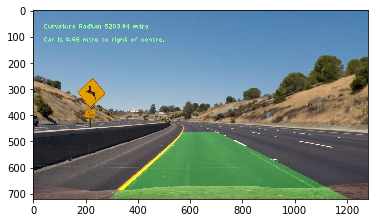

In [23]:
warped = mpimg.imread('output_images/top_down.jpg')
left_fit, right_fit, _, _, _ = slidingW_fit(warped)
#sp_left_fit, sp_right_fit, _, _ = search_around_poly(warped, left_fit, right_fit)
plt.imshow(data_marker(lane_marker(img, warped, left_fit, right_fit, Minv), 5786.51482567, 4620.77351739, +0.681441810305))
plt.show()

In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        # self.current_fit = [np.array([False])]  
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
    def process_new_fit(self, fit, inds):
        if fit is None:
            self.detected = False
        else:
            # New FIT is a good one        
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit - self.best_fit)
                if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                    # way off the BEST FIT, skip it
                    self.detected = False
                else:
                    self.detected = True
                    self.px_count = np.count_nonzero(inds)
                    self.current_fit.append(fit)
                    if len(self.current_fit) > 5:
                        self.current_fit = self.current_fit[len(self.current_fit)-5:]
                    self.best_fit = np.average(self.current_fit, axis=0)
            else:
                # self.best_fit does not exist
                self.detected = True
                self.current_fit.append(fit)
                self.best_fit = fit
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]


In [25]:
def complete_pipeline(img):
    
    imgC = np.copy(img)
    th_img = apply_grad_color_threshold(imgC)
    top_down, perspective_M, Minv = top_down_view(th_img)
    if l_obj.detected and r_obj.detected:
        left_fit, right_fit, l_lane_inds, r_lane_inds = search_around_poly(top_down, l_obj.best_fit, r_obj.best_fit)
    else:
        left_fit, right_fit, l_lane_inds, r_lane_inds, _ = slidingW_fit(top_down, debug_mode=False)

    if left_fit is not None and right_fit is not None:
        l_obj.process_new_fit(left_fit, l_lane_inds)
        r_obj.process_new_fit(right_fit, r_lane_inds)
    
        left_curverad, right_curverad, off_set = measure_curvature_pixels(top_down, l_obj.best_fit, r_obj.best_fit)
        imgO = data_marker(lane_marker(imgC, top_down, l_obj.best_fit, r_obj.best_fit, Minv), left_curverad, right_curverad, off_set)
        return imgO
    else:
        return imgC


In [26]:
l_obj = Line()
r_obj = Line()

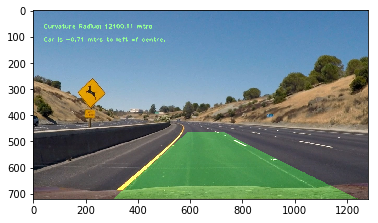

In [28]:
# Test
image = mpimg.imread('test_images/test2.jpg')
outt = complete_pipeline(image)
plt.imshow(outt)
plt.show()

In [27]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(complete_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:04<00:00,  3.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 7s, sys: 1min 18s, total: 9min 26s
Wall time: 6min 5s
